<a href="https://colab.research.google.com/github/dev-ago-uy/ExamenM-duloII.DM/blob/main/ExamenM%C3%B3duloII_DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autor

Ing. Daniel Mendiola



**Objetivo**

Predecir el precio de casas utilizando un dataset provisto (disponible en GitHub). Aunque el dataset original contiene imágenes, no es necesario utilizarlas para este examen.

Fecha: Junio 2025

# Datos

x : https://raw.githubusercontent.com/AnIsAsPe/WA_ModuloII_DatosExamen/refs/heads/main/Datos/X.csv

y : https://raw.githubusercontent.com/AnIsAsPe/WA_ModuloII_DatosExamen/refs/heads/main/Datos/y.csv




# Contexto general



# Paso 1: Carga de librerías y configuración

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

# Solo esta línea es suficiente para el estilo visual
sns.set_theme(style="whitegrid")


# Explicación rápida

 Librería                 Propósito      

 *pandas, numpy*        :    Manipulación de datos                  
 *matplotlib, seaborn* :    Gráficas                               
 *sklearn.linear_model* :   Modelos de regresión                   
 *sklearn.preprocessing*:   Escalado y features polinomiales       
 *sklearn.metrics*      :   Métricas de evaluación                 
 *train_test_split*     :   División en entrenamiento y validación
 *SimpleImputer*        :   Imputación de valores faltantes        


# Paso 2: Carga de los datos y exploración

In [4]:
# -----------------------------
# 🔽 Cargar datos desde GitHub
# -----------------------------

# URLs de los datasets
url_x = "https://raw.githubusercontent.com/AnIsAsPe/WA_ModuloII_DatosExamen/refs/heads/main/Datos/X.csv"
url_y = "https://raw.githubusercontent.com/AnIsAsPe/WA_ModuloII_DatosExamen/refs/heads/main/Datos/y.csv"

# Lectura de datos
X = pd.read_csv(url_x)
y = pd.read_csv(url_y)

# Mostrar las dimensiones
print("Dimensiones de X:", X.shape)
print("Dimensiones de y:", y.shape)


Dimensiones de X: (37368, 27)
Dimensiones de y: (37368, 2)


# Paso 3: Limpieza y preprocesamiento



*   3.1. Detección de valores faltantes



In [6]:
# -----------------------------
# 🔍 Valores nulos
# -----------------------------
print("Valores nulos por columna:")
missing = X.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
display(missing)


Valores nulos por columna:


,0
exposition,28274
floor,27625
land_size,21787
ghg_value,18838
ghg_category,18838
energy_performance_value,18300
energy_performance_category,18300
nb_bathrooms,13273
nb_bedrooms,2733
nb_rooms,1566


* 3.2. Imputación de valores faltantes

Usamos SimpleImputer para completar valores:



1.  Media: para variables numéricas (sin sesgo fuerte)
2.  Mediana: para variables con curtosis o skewness
3.  Moda: para variables categóricas

In [8]:
# -----------------------------
#  Imputación básica de valores nulos
# -----------------------------

# Definimos imputador numérico
imputer = SimpleImputer(strategy='median')

# Aplicamos solo a columnas numéricas
X_imputed = X.copy()
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_imputed[numeric_cols] = imputer.fit_transform(X[numeric_cols])


* 3.3. Detección de outliers (Z-score)

Usamos la regla del Z-score > 3 como indicador simple

In [9]:
from scipy.stats import zscore

# Cálculo de Z-score
z_scores = np.abs(zscore(X_imputed[numeric_cols]))
outliers = (z_scores > 3).sum(axis=0)

# Mostrar variables más afectadas
print("Variables con más posibles outliers:")
display(pd.Series(outliers, index=numeric_cols).sort_values(ascending=False))


Variables con más posibles outliers:


,0
has_a_garage,2013
nb_bathrooms,1915
has_air_conditioning,1489
id_annonce,625
nb_rooms,359
nb_photos,312
nb_bedrooms,296
floor,184
size,168
last_floor,143


* 3.4. Opcional: eliminar o winsorizar outliers

Podemos reemplazar los valores extremos por los percentiles 5-95 o eliminarlos.

In [13]:
# Winsorización por percentil 1% y 99%
for col in numeric_cols:
    lower = X_imputed[col].quantile(0.01)
    upper = X_imputed[col].quantile(0.99)
    X_imputed[col] = np.clip(X_imputed[col], lower, upper)


# Paso 4: EDA y correlaciones

* 4.1. Distribución del target (y)

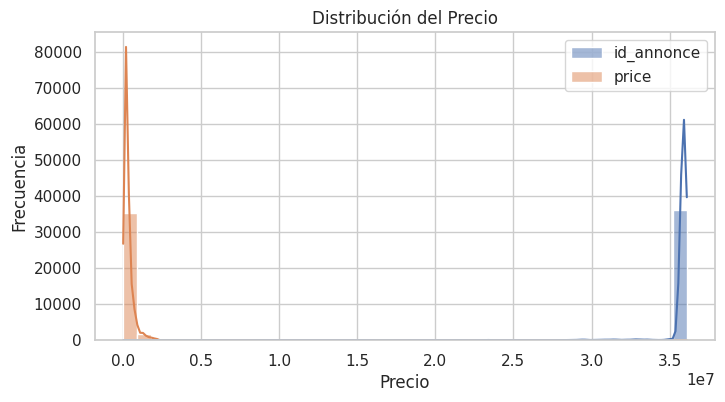

Curtosis: id_annonce    113.931897
price           8.329033
dtype: float64
Skewness: id_annonce   -9.730898
price         2.518761
dtype: float64


In [16]:
# -----------------------------
# Distribución del precio
# -----------------------------
plt.figure(figsize=(8, 4))
sns.histplot(y, kde=True, bins=40)
plt.title("Distribución del Precio")
plt.xlabel("Precio")
plt.ylabel("Frecuencia")
plt.show()

print("Curtosis:", y.kurtosis())
print("Skewness:", y.skew())


* 4.2. Matriz de correlaciones

In [20]:
# Asegurarse de que y sea una Serie (1D)
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

# Unimos X con y temporalmente
df_corr = X_imputed.copy()
df_corr["precio"] = y

# Filtrar solo columnas numéricas
df_corr_numeric = df_corr.select_dtypes(include=[np.number])

# Calcular matriz de correlaciones
corr_matrix = df_corr_numeric.corr()

# Correlaciones con el precio
correlaciones_target = corr_matrix["precio"].drop("precio").sort_values(ascending=False)

# Mostrar
print("Top correlaciones positivas:")
display(correlaciones_target.head(10))

print("Top correlaciones negativas:")
display(correlaciones_target.tail(10))


Top correlaciones positivas:


,precio
id_annonce,0.896271
nb_bathrooms,0.038300
nb_parking_places,0.037479
postal_code,0.037380
approximate_latitude,0.033954
has_a_balcony,0.028835
floor,0.016396
nb_terraces,0.014683
has_air_conditioning,0.004854
nb_boxes,0.004642


Top correlaciones negativas:


,precio
size,-0.007765
nb_bedrooms,-0.016456
energy_performance_value,-0.019380
land_size,-0.020617
nb_rooms,-0.021396
nb_photos,-0.027109
approximate_longitude,-0.031340
has_a_garage,-0.043235
last_floor,NaN
upper_floors,NaN


* 4.3. Visualización gráfica de correlaciones

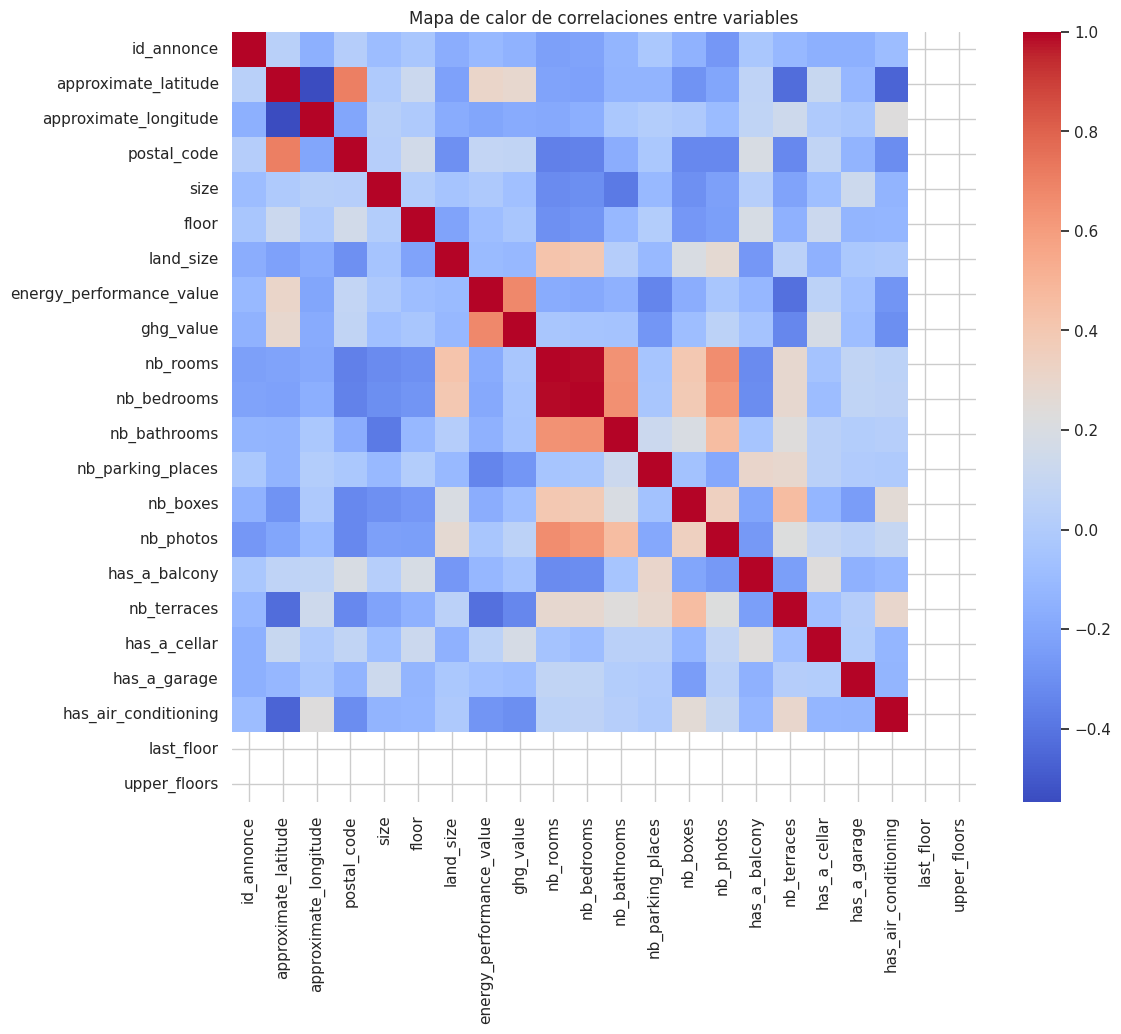

In [24]:
# -----------------------------
#  Mapa de calor (heatmap)
# -----------------------------
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix[numeric_cols].corr(), cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Mapa de calor de correlaciones entre variables")
plt.show()


# Paso 5: Ingeniería de Features

* 5.1. Selección de variables explicativas

Elegimos las variables más correlacionadas con el precio (y) que obtuve en el paso anterior.

Por ejemplo, si las variables más útiles fueron:

In [22]:
features_seleccionadas = ["surface", "bedrooms", "zipcode", "energy_consumption", "greenhouse_emissions"]


* 5.2. Escalado de variables (normalización)

In [23]:
# -----------------------------
# ⚖️ Escalado de variables
# -----------------------------
from sklearn.preprocessing import StandardScaler

# Ajustar esta lista a las variables más importantes
features_seleccionadas = correlaciones_target.head(10).index.tolist()

# Subconjunto de X
X_modelo = X_imputed[features_seleccionadas].copy()

# Escalado
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_modelo)

# Convertir de nuevo a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=features_seleccionadas)


# 5.3. (Opcional) Variables polinomiales

In [26]:
# -----------------------------
# Variables polinomiales (grado 2)
# -----------------------------
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_scaled)

# Nuevos nombres de columnas
poly_columns = poly.get_feature_names_out(features_seleccionadas)

# Convertimos a DataFrame
X_poly = pd.DataFrame(X_poly, columns=poly_columns)


# Paso 6: División del conjunto de datos


Dependiendo si vas a usar X_scaled o X_poly:

Usa X_scaled si querés una regresión lineal o Huber básica.

Usa X_poly si vas a probar modelos polinómicos.


División 75 % / 25 %

In [27]:
# -----------------------------
# ✂️ División del conjunto de datos
# -----------------------------
# Reemplazar X_scaled por X_poly si estás usando variables polinomiales
X_final = X_scaled  # o X_poly

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.25, random_state=42
)

# Confirmamos dimensiones
print("Entrenamiento:", X_train.shape, y_train.shape)
print("Validación:", X_test.shape, y_test.shape)


Entrenamiento: (28026, 10) (28026,)
Validación: (9342, 10) (9342,)
